In [716]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors

In [760]:
class Creature():
    strains_full = ['Team', 'Selfish', 'Intelligent']
    strains = ['T', 'S', 'I']
    
    def __init__(self, strain):
        self.food = 0
        self.strain = strain
        
    def reproduce(self, mutation_table):
        out = []
        for i in range(int(self.food//1 + ((self.food - self.food//1) > np.random.rand()))):
            new_strain = np.random.choice(self.strains, p=list(mutation_table[self.strain].values()))
            out.append(Creature(new_strain))
        return out
    
    def __str__(self):
        return f'{self.food}, {self.strain}'

In [770]:
class Tree():
    def __init__(self, **params):
        self.bot_layer, self.top_layer, self.team_cost, self.self_cost = tuple(params.values())
        
        self.tables = {'T': {'T': (self.bot_layer + self.top_layer) / 2 - self.team_cost, 'S': self.bot_layer/4}, 
                       'S': {'T': self.bot_layer * 3/4, 'S': self.bot_layer / 2 - self.self_cost}}
        self.creatures = []
        
    def harvest(self):
        if len(self.creatures) == 0: 
            return
        elif len(self.creatures) == 1:
            self.creatures[0].food = self.bot_layer
        else:
            strain0 = self.creatures[0].strain
            strain1 = self.creatures[1].strain
            
            if self.creatures[0].strain == 'I' and self.creatures[1].strain != 'I':
                strain0 = 'T' if self.tables['T'][self.creatures[1].strain] > self.tables['S'][self.creatures[1].strain] else 'S'
            elif self.creatures[0].strain != 'I' and self.creatures[1].strain == 'I':
                strain1 = 'T' if self.tables['T'][self.creatures[0].strain] > self.tables['S'][self.creatures[0].strain] else 'S'
            elif self.creatures[0].strain == 'I' and self.creatures[1].strain == 'I':
                strain0 = 'T'
                strain1 = 'T'
            
            self.creatures[0].food = self.tables[strain0][strain1]
            self.creatures[1].food = self.tables[strain1][strain0]
            
    def reset(self):
        self.creatures = []

In [773]:
class Simulator():
    def __init__(self, init_creatures=10, init_trees=50, mutation_table=[]):
        self.init_creatures = init_creatures
        self.reset_creatures()
        
        self.init_trees = init_trees
        self.default_tree_params = {'bot_layer': 2, 'top_layer': 2, 'team_cost': 1/4, 'self_cost': 1/4}
        self.set_trees(**self.default_tree_params)
            
        if mutation_table:
            self.mutation_table = mutation_table
        else:
            self.mutation_table = {'T': {'T': 1, 'S': 0, 'I': 0},
                                   'S': {'T': 0, 'S': 1, 'I': 0},
                                   'I': {'T': 0, 'S': 0, 'I': 1}}
            
    def set_trees(self, **params):
        """
        Args:
            **params: Must be of the form {bot_layer: , top_layer: , team_cost: , self_cost: }
        """
        self.trees = np.array([Tree(**params) for _ in range(self.init_trees)])
        
    def reset_creatures(self, *args):
        if args:
            self.creatures = np.array([Creature(Creature.strains[i]) for i, v in enumerate(args) for _ in range(v)])
        else:
            self.creatures = np.array([Creature('S' if 0.5 > np.random.rand() else 'T') for _ in range(self.init_creatures)])
            
    def reset_trees(self):
        for tree in self.trees: tree.reset()
        
    def find_trees(self):
        for i in range(min(2*self.init_trees, len(self.creatures))):
            self.trees[i%self.init_trees].creatures.append(self.creatures[i])
        
    def harvest_trees(self):
        for tree in self.trees: tree.harvest()
        
    def next_gen(self):
        num_creatures = len(self.creatures)
        
        for i in range(num_creatures): 
            self.creatures = np.append(self.creatures, self.creatures[i].reproduce(self.mutation_table))
        for _ in range(num_creatures): 
            self.creatures = self.creatures[1:]
            
        np.random.shuffle(self.creatures)
            
    def print_creatures(self):
        for creature in self.creatures: print(str(creature))
        
    def count_creatures(self, strain=None):
        strains = [creature.strain for creature in self.creatures]
        return strains.count(strain) if strain else [strains.count(strain) for strain in Creature.strains]
        
    def update_data(self, data, with_counts):
        counts = self.count_creatures()
        props = [count / len(self.creatures) for count in counts]
        return np.append(data, counts if with_counts else props)
            
    def day(self):
        self.reset_trees()
        self.find_trees()
        self.harvest_trees()
        self.next_gen()
        
    def run(self, days=100, sims=1, with_counts=False):
        self.data = []
        
        for i in range(sims):
            num_creatures = [round(elem*self.init_creatures/(sims+1)) for elem in [i+1, sims-i]]
            self.reset_creatures(*num_creatures)
            new_data = self.update_data([], with_counts)
            
            for _ in range(days):
                self.day()
                new_data = self.update_data(new_data, with_counts)
            self.data = np.append(self.data, new_data.reshape(days+1, len(Creature.strains)).T)
            
        self.data = self.data.reshape(sims, len(Creature.strains), days+1)
            
    def plot_data(self):
        fig, ax = plt.subplots()
        
        legend = Creature.strains_full[:-1]
        dshape = self.data.shape
        
        x = np.arange(0, dshape[2])
        avgs = np.zeros(dshape[1:])
        
        for i in range(dshape[0]):
            sum = np.zeros(dshape[2])
            for j in range(dshape[1]):
                sum += self.data[i][j]
                avgs[j] += self.data[i][j]
                ax.plot(x, sum, color='#FFFFFF')
                
        avgs /= dshape[0]
        ax.stackplot(x, *avgs, labels=legend, colors=colors.TABLEAU_COLORS)
        
        ax.legend()
        ax.set(title="Creatures Over Time")
        plt.show()

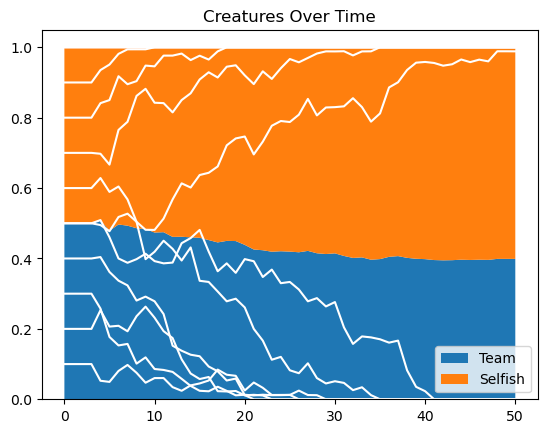

In [775]:
mutation_table = {'T': {'T': 0.98, 'S': 0.01, 'I': 0.01},
                  'S': {'T': 0.01, 'S': 0.98, 'I': 0.01},
                  'I': {'T': 0.01, 'S': 0.01, 'I': 0.98}}
simulator = Simulator()
simulator.run(50, 10)
simulator.plot_data()